In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_categorical
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import lightgbm as lgm
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import scipy
from scipy.cluster import hierarchy as hc

In [3]:
# used functionality 

def mad(x,y): return sum(abs(x-y))/len(x)

def handle_multi_string_columns(df, column, single_strings):
    '''
    Replaces column whose fields contain several strings with new columns. Each
    new column will then represent a single string
    
    INPUT:
    df - the pandas dataframe you want to search
    column - the column name you want to look through
    single_strings - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - The dataframe without the multi-string column but with the newly created columns
    col_dict - Dictionary translating names of the new columns to their corresponding string
    '''
    
    #collects new columns of indicating if a certain index refers to a string 
    new_columns = dict()
    
    #dict column name -> string name
    col_dict = dict()
    
    #loop through list of strings
    counter = 0
    for string in single_strings:
        bool_list = []
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row set to True
            if string in str(df[column][idx]):
                bool_list.append(1)
            else:
                bool_list.append(0)
        col_name = column + "_" + str(counter)
        new_columns[col_name] = bool_list
        col_dict[col_name] = string
        counter = counter + 1
    
    new_df = df.drop(column,axis=1)
    
    new_df = pd.concat([new_df, pd.DataFrame(data=new_columns, index = df.index, dtype=int)], axis=1)
    
    return new_df, col_dict


def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

def mean_absolute_error_2(y_true, y_pred):
    return mean_absolute_error(y_true, np.round(y_pred))


def classification(y_train, y_test_preds):
    y_train_min = np.min(y_train)
    y_train_max = np.max(y_train)
    total_distance = y_train_max - y_train_min
    point_0 = y_train_min + total_distance * np.sum(y_train == 0) / len(y_train)
    point_1 = point_0 + total_distance * np.sum(y_train == 1) / len(y_train)
    point_2 = point_1 + total_distance * np.sum(y_train == 2) / len(y_train)
    point_3 = point_2 + total_distance * np.sum(y_train == 3) / len(y_train)
    point_4 = y_train_max
    
    for i in range(len(y_test_preds)):
        if y_test_preds[i] <= point_0:
            y_test_preds[i] = 0
        elif y_test_preds[i] <= point_1:
            y_test_preds[i] = 1
        elif y_test_preds[i] <= point_2:
            y_test_preds[i] = 2
        elif y_test_preds[i] <= point_3:
            y_test_preds[i] = 3
        elif y_test_preds[i] <= point_4:
            y_test_preds[i] = 4
        else:
            print("An error occurred!")
            break
    
        return y_test_preds

In [4]:
df_raw = pd.read_csv('survey_results_public.csv', low_memory=False)
schema = pd.read_csv('survey_results_schema.csv')

In [5]:
df = df_raw.dropna(subset=['JobSat'], axis=0)
df = df[df.Employment.isin(['Employed full-time', 'Employed part-time'])]
df = df[df.Student == 'No']
df = df.drop(['CareerSat','Respondent','ResumeUpdate','CurrencySymbol','CurrencyDesc','CompTotal','SurveyEase','SurveyLength','SONewContent','WelcomeChange','SOComm','EntTeams','SOVisit1st',
                 'SOVisitFreq', 'SOVisitTo', 'SOFindAnswer', 'SOTimeSaved', 'SOHowMuchTime', 'SOAccount','SOPartFreq', 'SOJobs', 'LanguageWorkedWith', 'LanguageDesireNextYear',
                 'DatabaseWorkedWith', 'DatabaseDesireNextYear', 'PlatformWorkedWith', 'PlatformDesireNextYear', 'WebFrameWorkedWith', 'WebFrameDesireNextYear', 'MiscTechWorkedWith', 
                 'MiscTechDesireNextYear', 'DevEnviron','Student','Ethnicity','JobSeek','MgrIdiot'], axis=1)
df = df.dropna(thresh=45)
df = df.reset_index(drop=True)

In [6]:
EduOther_strings = ['Taken an online course in programming or software development (e.g. a MOOC)','Participated in a fulltime developer training program or bootcamp',
                    'Taken a part-time in-person course in programming or software development','Completed an industry certification program (e.g. MCPD)',
                    'Received on-the-job training in software development','Taught yourself a new language, framework, or tool without taking a formal course',
                    'Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)','Participated in a hackathon','Contributed to open source software',
                    'None of these']

DevType_strings = ['Academic researcher','Data or business analyst','Data scientist or machine learning specialist','Database administrator','Designer','Developer, back-end',
                   'Developer, desktop or enterprise applications','Developer, embedded applications or devices','Developer, front-end','Developer, full-stack',
                   'Developer, game or graphics','Developer, mobile','Developer, QA or test','DevOps specialist','Educator','Engineer, data','Engineer, site reliability',
                   'Engineering manager','Marketing or sales professional','Product manager','Scientist',"Senior Executive (C-Suite, VP, etc.)", 'Student', 'System administrator']

LastInt_strings = ['Write any code','Write code by hand (e.g., on a whiteboard)','Complete a take-home project','Solve a brain-teaser style puzzle','Interview with people in peer roles',
                   'Interview with people in senior / management roles']

WorkChallenge_strings = ['Distracting work environment','Being tasked with non-development work','Meetings','Time spent commuting','Not enough people for the workload',
                         'Toxic work environment','Inadequate access to necessary tools','Lack of support from management','Non-work commitments (parenting, school work, hobbies, etc.)']

JobFactors_strings = ['Diversity of the company or organization',"Languages, frameworks, and other technologies I'd be working with","Industry that I'd be working in",
                      'How widely used or impactful my work output would be',"Specific department or team I'd be working on",'Flex time or a flexible schedule',
                      'Remote work options','Financial performance or funding status of the company or organization','Office environment or company culture',
                      'Opportunities for professional development']

df, dict_EduOther = handle_multi_string_columns(df,"EduOther",EduOther_strings)
df, dict_DevType = handle_multi_string_columns(df,"DevType",DevType_strings)
df, dict_LastInt = handle_multi_string_columns(df,"LastInt",LastInt_strings)
df, dict_WorkChallenge = handle_multi_string_columns(df,"WorkChallenge",WorkChallenge_strings)
df, dict_JobFactors = handle_multi_string_columns(df,"JobFactors",JobFactors_strings)

In [7]:
for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

df.JobSat.cat.set_categories(['Very dissatisfied','Slightly dissatisfied','Neither satisfied nor dissatisfied','Slightly satisfied', 'Very satisfied'], ordered=True, inplace=True)
#df.JobSeek.cat.set_categories(['I am not interested in new job opportunities','I’m not actively looking, but I am open to new opportunities','I am actively looking for a job'], ordered=True, inplace=True)

### Attempt at feature engineering

How many work place challenges were selected?

In [8]:
df["WorkChallenge_count"] = 0
df["WorkChallenge_count"] = sum([
    df["WorkChallenge_count"] + df["WorkChallenge_{}".format(i)] for i in range(len(WorkChallenge_strings))
])

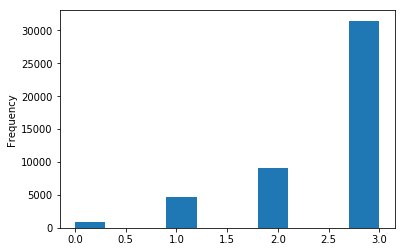

In [9]:
df.WorkChallenge_count.plot.hist()

Average salary in country

In [10]:
#average_salary_country = df.groupby("Country").apply(lambda df: df.ConvertedComp.mean()).reset_index()
df["Average_salary_country"] = None
for country in df.Country.unique():
    df.loc[df.Country==country, "Average_salary_country"] = df.loc[df.Country==country, "ConvertedComp"].mean()

Diff between own salary and average salary in country

In [11]:
df["Diff_to_average_country_salary"] = df.ConvertedComp-df.Average_salary_country

In [12]:
df_indicator = df.isnull().astype(int).add_suffix('_nan')
df = pd.concat([df, df_indicator], axis=1)

In [13]:
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

fill_mean = lambda col: col.fillna(col.mean())
# Fill the mean
df = df.apply(fill_mean, axis=0)

In [14]:
#Drop columns with all NaN values
df = df.dropna(how='all', axis=0)
df = df.dropna(how='all', axis=1)
#delete columns that add up to 0
df = df.loc[:, (df != 0).any(axis=0)]

In [18]:
X = df.drop(['JobSat'], axis=1)
y = df['JobSat']

X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.4, random_state=14)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=14)

In [19]:
# Grid search for good parameters, I used the mean absolute error as the main measure of quality
param_grid = {'num_leaves': [8,10,20,31],
              'learning_rate': [0.09, 0.1, 0.11, 0.12,0.15],
              'max_bin': [255, 270, 280]}
grid = GridSearchCV(lgm.LGBMRegressor(), param_grid=param_grid,cv=5, return_train_score=True)
X_train_grit = X_train.sample(frac=0.5, random_state=42)
grid.fit(X_train_grit, y_train.loc[X_train_grit.index])
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

best mean cross-validation score: 0.160
best parameters: {'learning_rate': 0.11, 'max_bin': 270, 'num_leaves': 8}
test-set score: 0.164


In [20]:
model = lgm.LGBMRegressor(n_estimators=300, 
                          num_leaves=grid.best_params_['num_leaves'],
                          learning_rate=grid.best_params_['learning_rate'],
                          max_bin=grid.best_params_['max_bin'])
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.11, max_bin=270,
       max_depth=-1, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=8,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [21]:
#Predict using your model
y_test_preds = model.predict(X_test)
y_train_preds =model.predict(X_train)
#Score using your model
test_r2 = r2_score(y_test, y_test_preds)
train_r2 = r2_score(y_train, y_train_preds)
# train_mad = mad(y_train, classification(y_train, y_train_preds))
# test_mad = mad(y_test, classification(y_train, y_test_preds))

correct = lambda x, multi, add: multi * x + add
corrector = 0 
train_mad = 1
for add in range(-100, 100):
    for multi in range (0, 200):
        new_mad = mad(y_train, np.round(correct(y_train_preds, multi/100, add/100)))
        if new_mad < train_mad:
            train_mad = new_mad
            multi_final = multi / 100
            add_final = add / 100

test_mad = mad(y_test, np.round(correct(y_test_preds, multi_final,add_final)))

print("Multiplier: {}".format(multi_final))
print("Scalar: {}".format(add_final))
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_r2, test_r2))
print("The mad on the training data was {}.  The mad on the test data was {}.".format(train_mad, test_mad))

Multiplier: 1.38
Scalar: -0.88
The rsquared on the training data was 0.26177372679820965.  The rsquared on the test data was 0.18050511534751468.
The mad on the training data was 0.7889570552147239.  The mad on the test data was 0.8700876908087041.


In [15]:
[np.sum(y_test == 0) , np.sum(y_test == 1), np.sum(y_test == 2), np.sum(y_test == 3), np.sum(y_test == 4)]

[654, 1441, 1012, 3214, 2916]

In [17]:
[np.sum(np.round(correct(y_test_preds, multi_final,add_final)) == 0) , np.sum(np.round(correct(y_test_preds, multi_final,add_final)) == 1), np.sum(np.round(correct(y_test_preds, multi_final,add_final)) == 2), np.sum(np.round(correct(y_test_preds, multi_final,add_final)) == 3), np.sum(np.round(correct(y_test_preds, multi_final,add_final)) == 4)]

[4, 241, 2175, 4723, 2090]

In [19]:
[np.sum(np.round(y_test_preds) == 0) , np.sum(np.round(y_test_preds) == 1), np.sum(np.round(y_test_preds) == 2), np.sum(np.round(y_test_preds) == 3), np.sum(np.round(y_test_preds) == 4)]

[0, 123, 2909, 5849, 356]

### Feature importance 

In [22]:
fi = rf_feat_importance(model, X_train)

In [23]:
model.feature_importances_

array([  3,   2,  20,  16,  10,  53,  18,  37,  39,  45,  59,  48,  29,
        27,  56,   4,   3, 111,  55,  43,  31,  59,  69,  29,  46,  55,
        52,  54,  23,  54,  35,  26,  31,  18,  15,  33,  18,  14,  87,
        14,   5,   8,  12,   6,   4,   9,  16,   5,  10,  11,   9,   5,
         6,   9,   1,   4,  12,  10,   4,   5,   7,   2,   5,   2,   9,
         9,   3,   4,   6,   0,   2,   8,   1,   3,   2,   6,  10,   6,
         6,  10,  10,  12,  13,  11,   6,  47,   9,  22,  19,   0,   6,
         1,   9,   5,   8,   2,   3,  18,  11,  35,  81,  73,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   0,
         0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0])

In [32]:
fi.sort_values(by="imp", ascending=False)
fi.iloc[:30,:]["cols"]

17                      ConvertedComp
38                                Age
100            Average_salary_country
101    Diff_to_average_country_salary
22                             ImpSyn
21                            WorkLoc
10                         Age1stCode
14                       LastHireDate
25                          UnitTests
18                        WorkWeekHrs
29                         Containers
27                       PurchaseWhat
5                             Country
26                        PurchaseHow
11                       YearsCodePro
85                    WorkChallenge_5
24                         CodeRevHrs
9                           YearsCode
19                           WorkPlan
8                             OrgSize
7                      UndergradMajor
30                      BlockchainOrg
99                WorkChallenge_count
35                        SocialMedia
32                         BetterLife
20                         WorkRemote
23          

In [42]:
X = df.drop(['JobSat']+list(fi.iloc[30:,:]["cols"]), axis=1)
y = df['JobSat']

X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.4, random_state=14)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=14)

param_grid = {'num_leaves': [8,10,20,31],
              'learning_rate': [0.09, 0.1, 0.11, 0.12,0.15],
              'max_bin': [255, 270, 280]}
grid = GridSearchCV(lgm.LGBMRegressor(), param_grid=param_grid,cv=5, return_train_score=True)
#X_train_grit = X_train.sample(frac=0.5, random_state=42)
grid.fit(X_train, y_train.loc[X_train.index])
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

best mean cross-validation score: 0.145
best parameters: {'learning_rate': 0.15, 'max_bin': 255, 'num_leaves': 8}
test-set score: 0.157


In [43]:
model = lgm.LGBMRegressor(n_estimators=300, 
                          num_leaves=grid.best_params_['num_leaves'],
                          learning_rate=grid.best_params_['learning_rate'],
                          max_bin=grid.best_params_['max_bin'])
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.15, max_bin=255,
       max_depth=-1, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=8,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [44]:
#Predict using your model
y_test_preds = model.predict(X_test)
y_train_preds =model.predict(X_train)
#Score using your model
test_r2 = r2_score(y_test, y_test_preds)
train_r2 = r2_score(y_train, y_train_preds)
# train_mad = mad(y_train, classification(y_train, y_train_preds))
# test_mad = mad(y_test, classification(y_train, y_test_preds))

correct = lambda x, multi, add: multi * x + add
corrector = 0 
train_mad = 1
for add in range(-100, 100):
    for multi in range (0, 200):
        new_mad = mad(y_train, np.round(correct(y_train_preds, multi/100, add/100)))
        if new_mad < train_mad:
            train_mad = new_mad
            multi_final = multi / 100
            add_final = add / 100

test_mad = mad(y_test, np.round(correct(y_test_preds, multi_final,add_final)))

print("Multiplier: {}".format(multi_final))
print("Scalar: {}".format(add_final))
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_r2, test_r2))
print("The mad on the training data was {}.  The mad on the test data was {}.".format(train_mad, test_mad))

Multiplier: 1.43
Scalar: -0.96
The rsquared on the training data was 0.25225322020357055.  The rsquared on the test data was 0.15766773179815907.
The mad on the training data was 0.798845182244677.  The mad on the test data was 0.8844863050774061.


In [45]:
rf_feat_importance(model, X_train)

,cols,imp
9,ConvertedComp,153
29,Diff_to_average_country_salary,134
25,Age,123
4,Age1stCode,104
10,WorkWeekHrs,101
3,YearsCode,88
5,YearsCodePro,88
28,Average_salary_country,87
16,CodeRevHrs,86
0,Country,85


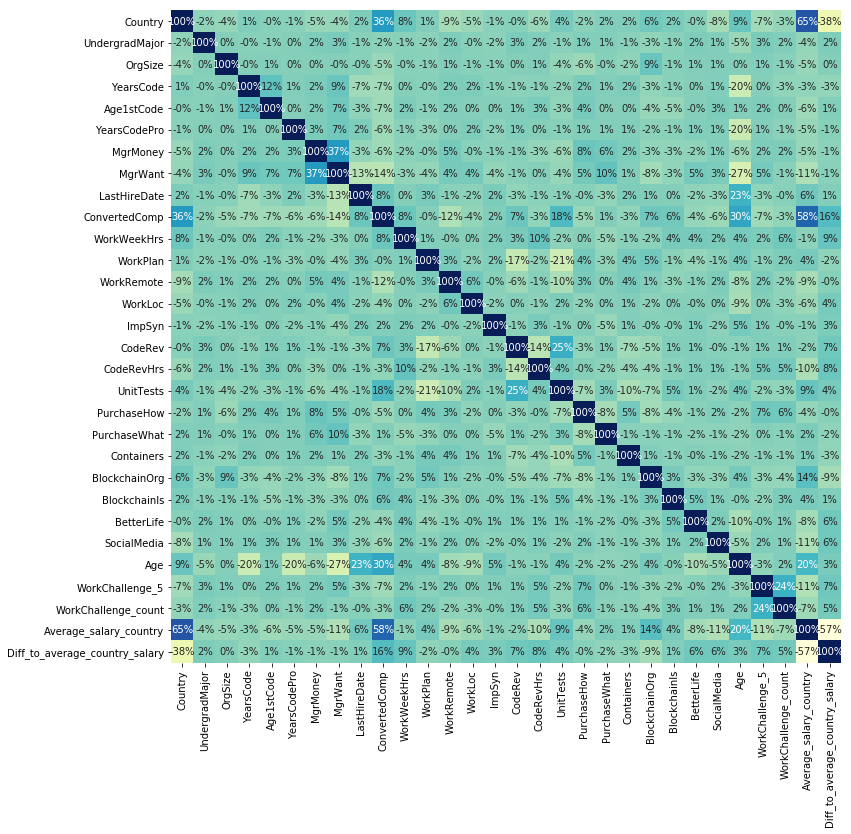

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(12,12)
sns.heatmap(scipy.stats.spearmanr(X_train).correlation,annot=True,fmt='.0%',cmap="YlGnBu",ax=ax,cbar=False,xticklabels=X.columns,yticklabels=X.columns);

### Leave-one-out

In [24]:
frozen_params = grid.best_params_
frozen_params

{'learning_rate': 0.11, 'max_bin': 270, 'num_leaves': 8}

In [26]:
evaluation = pd.DataFrame(columns=["dropped_col", "corrector_mult", "corrector_add", "mad_test"])

In [33]:
DF = df[list(fi.iloc[:30:]['cols'])]

for col in DF.columns:
    X = DF.drop([col], axis=1)
    y = df['JobSat']
    X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.4, random_state=14)
    X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=14)

    model = lgm.LGBMRegressor(n_estimators=300, 
                              num_leaves=frozen_params['num_leaves'],
                              learning_rate=frozen_params['learning_rate'],
                              max_bin=frozen_params['max_bin'])
    model.fit(X_train, y_train)

    #Predict using your model
    y_test_preds = model.predict(X_test)
    y_train_preds =model.predict(X_train)
    #Score using your model
    test_r2 = r2_score(y_test, y_test_preds)
    train_r2 = r2_score(y_train, y_train_preds)
    # train_mad = mad(y_train, classification(y_train, y_train_preds))
    # test_mad = mad(y_test, classification(y_train, y_test_preds))

    correct = lambda x, multi, add: multi * x + add
    corrector = 0 
    train_mad = 1
    for add in range(-100, 100):
        for multi in range (0, 200):
            new_mad = mad(y_train, np.round(correct(y_train_preds, multi/100, add/100)))
            if new_mad < train_mad:
                train_mad = new_mad
                multi_final = multi / 100
                add_final = add / 100

    test_mad = mad(y_test, np.round(correct(y_test_preds, multi_final,add_final)))
    
    evaluation = evaluation.append([col, multi_final, add_final, test_mad])

In [ ]:
cols = evaluation.loc[evaluation.index==0, 0]
mult = evaluation.loc[evaluation.index==1, 0]
add = evaluation.loc[evaluation.index==2, 0]
mad = evaluation.loc[evaluation.index==3, 0]

eval_results = pd.DataFrame(data={"col_dropped": cols.values, "mult": mult.values, "add": add.values, "test_mad": mad.values})

In [50]:
eval_results.sort_values(by="test_mad", ascending=True)

,col_dropped,mult,add,test_mad
1,Age,1.35,-0.76,0.870088
0,ConvertedComp,1.42,-0.89,0.87182
21,OrgSize,1.32,-0.6,0.873552
25,SocialMedia,1.21,-0.36,0.878857
14,Country,1.4,-0.83,0.878965
8,Age1stCode,1.38,-0.86,0.879506
29,MgrMoney,1.36,-0.76,0.879831
26,BetterLife,1.29,-0.58,0.879831
5,Diff_to_average_country_salary,1.31,-0.64,0.879939
12,Containers,1.24,-0.4,0.879939


In [51]:
evaluation.to_csv("leave_one_out_result.csv", index=False)

In [75]:
rf_feat_importance(model, X_test_valid)

,cols,imp
1,Country,204
28,Age,158
11,WorkWeekHrs,138
7,YearsCodePro,119
6,Age1stCode,114
15,ImpSyn,107
17,CodeRevHrs,104
5,YearsCode,100
19,PurchaseHow,100
22,Containers,97
